# Libs utilizadas

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
import scipy
from scipy.stats import boxcox
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from modulos.estacionaridade import *
from modulos.testes_estacionarios import *
from modulos.Credito import *
from modulos.filtros import *
from modulos.carregamento import *

# Filtrando warnings
warnings.filterwarnings("ignore")

___

# 1 - Organização dos Dados
> Filtragem da base de dados

Carregando a base bruta

In [284]:
df1 = pd.read_csv('data/desepesa_2018_2024.csv', encoding='latin1', sep=';')

In [285]:
df = pd.read_excel('data/despesa_2014_2017.xlsx')

In [286]:
df1 = df1[['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]
df = df[['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]
df = pd.concat([df, df1])

In [287]:
df.columns

Index(['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO'], dtype='object')

Organizando a base

Selecionando as colunas para análise

Criação de uma coluna Ano e Mês

In [288]:
df.head()

,ANO,MES,PODER,UO,UG,FONTE_MAE,NATUREZA3,VALOR_EMPENHADO
0,2014,6,EXE,25016,410016,146,344000000,1137990.00
1,2014,9,MPE,3004,30004,100,331000000,210537.96
2,2014,5,MPE,3004,30004,100,331000000,190434.86
3,2014,11,EXE,20516,510516,100,331000000,174294.75
4,2014,6,EXE,20516,510516,100,331000000,182815.82


In [289]:
df['ANO_MES'] = df['ANO'].astype(str) + '-' + df['MES'].astype(str)

#### Filtro dos dados!
Definições: 
Unidade Gestora.  
Natureza.  
Poder.  

**FIltro de maior relevância!**

In [290]:
# UO == 21018, NATURZA3 == 331000000, PODER == 'EXE'
# SEFAZ, DESPESA COM PESSOAL E PODER EXECUTIVO
# df_test = df_test[df_test['UO'] == 21018]
# df_test = df_test[df_test['NATUREZA3'] == 331000000] # Filtrando a Natureza de Pessoal de Operação
# df_test = df_test[df_test['PODER'] == 'EXE'] # Apenas o poder executivo

In [291]:
df = df.sort_values(by=['ANO', 'MES']).reset_index(drop=True)

In [292]:
# Transformando em 'Object' ANO, MES, PODER, UO, UG, FONTE_MAE, NATUREZA3.
convertendo_obj = ['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3']
for column in convertendo_obj:
    df[column] = df[column].astype('object')

In [293]:
# Convertendo para Datetime ANO_MES 
df['ANO_MES'] = pd.to_datetime(df['ANO_MES'], format='%Y-%m')

> Verificação descritiva antes de AGRUPAR!

In [294]:
df['VALOR_EMPENHADO'].describe()

count    6.850470e+05
mean     1.861016e+05
std      2.469266e+06
min     -2.817000e+08
25%      3.500000e+01
50%      1.480000e+03
75%      1.350000e+04
max      3.690000e+08
Name: VALOR_EMPENHADO, dtype: float64

> Verificação de valor nulo ou ausente

In [295]:
df_valores_ruins = df[df['VALOR_EMPENHADO'] <= 0]
print(f'Quantidade de valores ruins: {df_valores_ruins.shape[0]}')
print(f'quantidade de vaores negativos: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] < 0].shape[0]}')
print(f'quantidade de valores 0: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] == 0].shape[0]}')

Quantidade de valores ruins: 165982
quantidade de vaores negativos: 26688
quantidade de valores 0: 139294


In [296]:
df.shape

(685047, 9)

In [297]:
quantidade_de_valor_ausente = df['VALOR_EMPENHADO'].isnull().sum().sum()
print(f'Quantidade de valores ausentes: {quantidade_de_valor_ausente}')

Quantidade de valores ausentes: 0


In [298]:
df['VALOR_EMPENHADO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 685047 entries, 0 to 685046
Series name: VALOR_EMPENHADO
Non-Null Count   Dtype  
--------------   -----  
685047 non-null  float64
dtypes: float64(1)
memory usage: 5.2 MB


> Verificação da porcentagem de valores atribuidos com '0'.

In [299]:
# Caclular a porcentagem de valores 0 em realcao ao total
porcentagem_de_zeros = df[df['VALOR_EMPENHADO'] == 0].shape[0] / df.shape[0] * 100
print(f'Porcetagem de valores 0: {porcentagem_de_zeros:.2f}%')

Porcetagem de valores 0: 20.33%


In [300]:
df = df[df['VALOR_EMPENHADO'] > 0]

In [301]:
df.shape

(519065, 9)


> Agrupando os dados na frêquencia 'MENSAL'.

In [302]:
# Agrupando
df = df.groupby(['ANO_MES'])['VALOR_EMPENHADO'].sum().reset_index()

In [303]:
df.head()

,ANO_MES,VALOR_EMPENHADO
0,2014-01-01,1.895801e+09
1,2014-02-01,5.287013e+08
2,2014-03-01,5.196278e+08
3,2014-04-01,5.844282e+08
4,2014-05-01,5.885324e+08


In [304]:
dados = df.copy()

> ! Setembro ainda não encerrou, então foi retirado da análise!

In [305]:
dados.tail()

,ANO_MES,VALOR_EMPENHADO
124,2024-05-01,1.482428e+09
125,2024-06-01,1.527629e+09
126,2024-07-01,1.549085e+09
127,2024-08-01,1.414779e+09
128,2024-09-01,2.474858e+08


In [306]:
# Setembro não acabou, então não temos o valor oficial de setembro de 2024
dados = dados[dados['ANO_MES'] != '2024-09-01']

In [307]:
# Setando o index
dados.index = dados['ANO_MES']
dados.drop('ANO_MES', axis=1, inplace=True)

In [308]:
dados.head()

,VALOR_EMPENHADO
ANO_MES,
2014-01-01,1.895801e+09
2014-02-01,5.287013e+08
2014-03-01,5.196278e+08
2014-04-01,5.844282e+08
2014-05-01,5.885324e+08


In [309]:
dados.tail()

,VALOR_EMPENHADO
ANO_MES,
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09
2024-06-01,1.527629e+09
2024-07-01,1.549085e+09
2024-08-01,1.414779e+09


> Dados está pronto para ser análisado

___

# 2 - Análise

Formatação Gŕafica - Padrão

In [310]:
# Formatação para gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500 )
pd.set_option('display.width', 1000)

In [311]:
# Formatando os Labels
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

> Atribuindo a coluna responsável pela 'data' como index, tornando o df em uma series

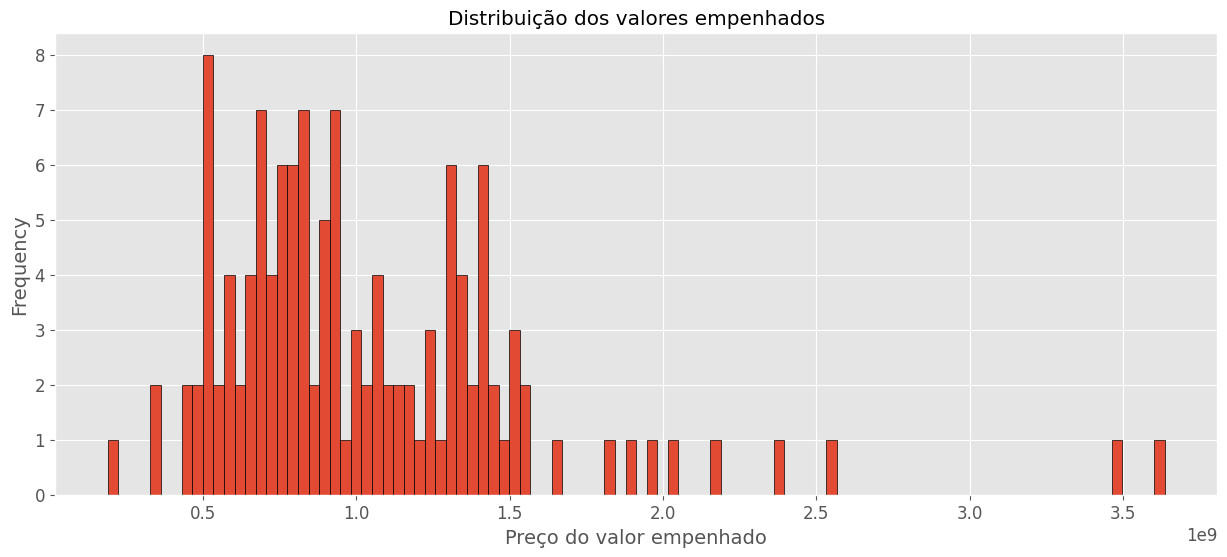

In [312]:
plt.figure(figsize=(15, 6))
dados['VALOR_EMPENHADO'].plot.hist(bins=100, grid=True, edgecolor='black').autoscale(enable=True)
plt.xlabel('Preço do valor empenhado')
plt.title('Distribuição dos valores empenhados')
plt.show()

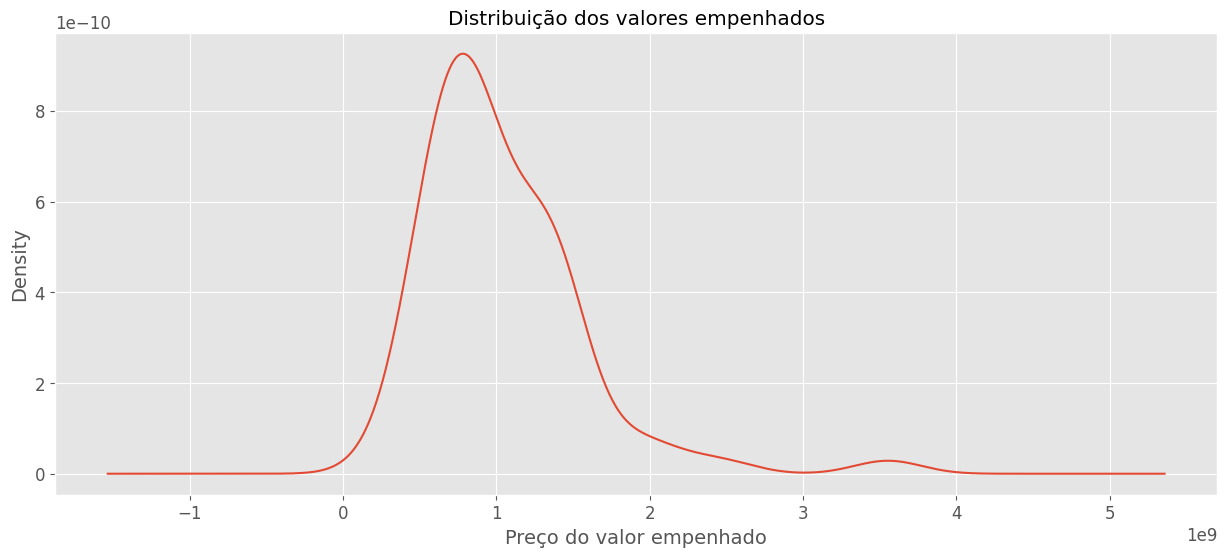

In [313]:
plt.figure(figsize=(15, 6))
dados['VALOR_EMPENHADO'].plot.kde()
plt.xlabel('Preço do valor empenhado')
plt.title('Distribuição dos valores empenhados')
plt.show()

<Figure size 1500x600 with 0 Axes>

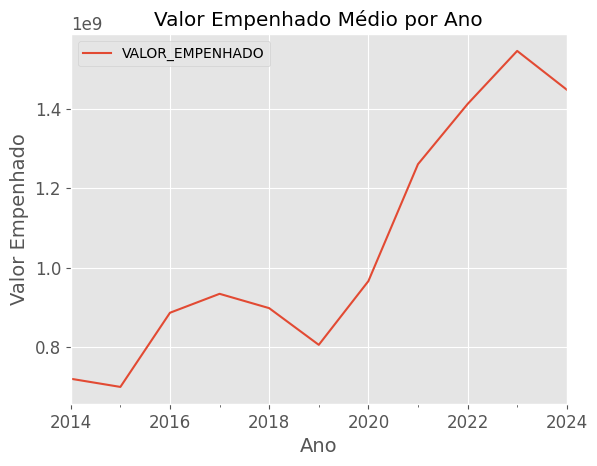

            VALOR_EMPENHADO
ANO_MES                    
2014-12-31     7.206163e+08
2015-12-31     7.000657e+08
2016-12-31     8.865330e+08
2017-12-31     9.341275e+08
2018-12-31     8.980974e+08
2019-12-31     8.058688e+08
2020-12-31     9.660434e+08
2021-12-31     1.260023e+09
2022-12-31     1.411240e+09
2023-12-31     1.544757e+09
2024-12-31     1.447297e+09


In [314]:
# valor medio do valor empnheado por ano, plo
plt.figure(figsize=(15, 6))
dados.resample('Y').mean().plot(grid=True)
plt.xlabel('Ano')
plt.ylabel('Valor Empenhado')
plt.title('Valor Empenhado Médio por Ano')
plt.show()
media_ano = dados.resample('Y').mean()
print(media_ano)

In [315]:
dados.shape

(128, 1)

In [316]:
dados_treino = dados.iloc[:-12]
dados_treino

,VALOR_EMPENHADO
ANO_MES,
2014-01-01,1.895801e+09
2014-02-01,5.287013e+08
2014-03-01,5.196278e+08
2014-04-01,5.844282e+08
2014-05-01,5.885324e+08
...,...
2023-04-01,1.334346e+09
2023-05-01,1.408602e+09
2023-06-01,1.407576e+09


In [317]:
dados_teste = dados.iloc[-12:]
dados_teste

,VALOR_EMPENHADO
ANO_MES,
2023-09-01,2.017830e+09
2023-10-01,1.038205e+09
2023-11-01,1.365538e+09
2023-12-01,3.473475e+09
2024-01-01,1.147500e+09
2024-02-01,1.369704e+09
2024-03-01,1.527246e+09
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09


In [318]:
dados_teste

,VALOR_EMPENHADO
ANO_MES,
2023-09-01,2.017830e+09
2023-10-01,1.038205e+09
2023-11-01,1.365538e+09
2023-12-01,3.473475e+09
2024-01-01,1.147500e+09
2024-02-01,1.369704e+09
2024-03-01,1.527246e+09
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09


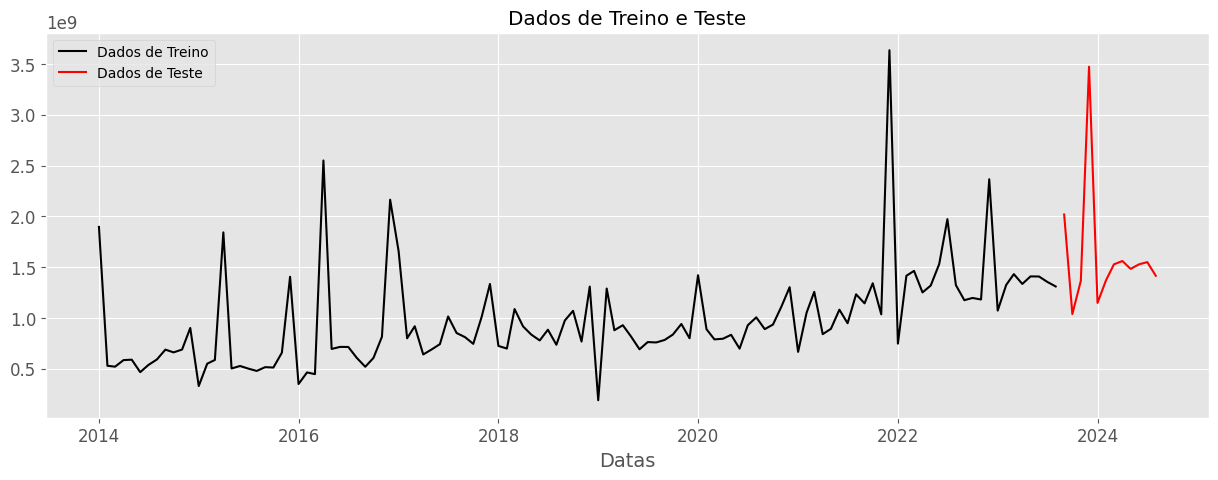

In [319]:
# Supondo que dados_treino e dados_teste são DataFrames do Pandas
plt.figure(figsize=(15, 5))
plt.plot(dados_treino, color='black', label='Dados de Treino')
plt.plot(dados_teste, color='red', label='Dados de Teste')
plt.title('Dados de Treino e Teste')
plt.xlabel('Datas')
plt.legend()
plt.show()

___

In [338]:
teste = dsa_testa_estacionaridade(dados)        


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.187659
Valor-p                           0.939977
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [341]:
dados_log = np.log1p(dados)

In [342]:
dsa_testa_estacionaridade(dados_log)


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.299637
Valor-p                           0.925556
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


False

In [343]:
dados_sqrt = np.sqrt(dados)

In [344]:
dsa_testa_estacionaridade(dados_sqrt)


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.175609
Valor-p                           0.941367
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


False

In [345]:
# diferenciacao
dados_diff = dados.diff().dropna()

In [346]:
dsa_testa_estacionaridade(dados_diff)


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -6.795898e+00
Valor-p                         2.301489e-09
Número de Lags Consideradas     1.000000e+01
Número de Observações Usadas    1.160000e+02
Valor Crítico (1%)             -3.488022e+00
Valor Crítico (5%)             -2.886797e+00
Valor Crítico (10%)            -2.580241e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


True

In [348]:
# A função "dsa_testa_estacionaridade" irá testar se a série é estacionária ou não. Irá retornar False, se a série não for estacionária e True, se a série for estacionária.
# Pseudo-código
# 1- Haverá o teste da estacionaridade com a função mencionada, caso retorne false, entrará no bloco de transformação e teste.
# 2- A primeira transformação seŕa a transformação logaritima, será testado a estacionaridade, caso retorne True o looping se encerra com um aviso print dizendo que apos transformacao logaritmica a serie se tornou estacionaria. Caso retorne False, entrara na proxima transformação


def estacionaridade_generalizada(dados):
    teste = dsa_testa_estacionaridade(dados)
    if teste == False:
        dados_log = np.log1p(dados)
        teste = dsa_testa_estacionaridade(dados_log)
        if teste == True:
            print('A série se tornou estacionária após a transformação logarítmica.')
            return dados_log
        else:
            dados_sqrt = np.sqrt(dados)
            teste = dsa_testa_estacionaridade(dados_sqrt)
            if teste == True:
                print('A série se tornou estacionária após a transformação raiz quadrada.')
                return dados_sqrt
            else:
                dados_diff = dados.diff().dropna()
                teste = dsa_testa_estacionaridade(dados_diff)
                if teste == True:
                    print('A série se tornou estacionária após a transformação de diferenciação.')
                    return dados_diff
                else:
                    print('A série não se tornou estacionária após as transformações.')
                    return dados
    else:
        print('A série já é estacionária.')
        return dados

In [353]:
resultado = estacionaridade_generalizada(dados)

dados


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.187659
Valor-p                           0.939977
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.

Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.299637
Valor-p                           0.925556
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


,VALOR_EMPENHADO
ANO_MES,
2014-01-01,1.895801e+09
2014-02-01,5.287013e+08
2014-03-01,5.196278e+08
2014-04-01,5.844282e+08
2014-05-01,5.885324e+08
...,...
2024-04-01,1.560008e+09
2024-05-01,1.482428e+09
2024-06-01,1.527629e+09
